The information contained in this csv file was taken from actual office records. The exact date of birth within the month was randomly changed for all entries due to HIPAA regulations. 
BMI is Body Mass Index. The next two columns are Date of Birth and Sex. The columns which follow represent whether there was the presence of non-insulin 
dependent diabetes mellitus, insulin dependent diabetes melitus, peripheral vascular disease (as evidenced by one or two non-palpable pedal pulses, 
skin atrophy, decreased hair, and nail changes), neuropathy (as evidenced by decreased sensation of the 5.07 Semmes-Weinstein monofilament fiber), 
the presence of hyperkeratosis (callus), the presence of an ulcer, the presence of cellulitis, and the first dates that these occurred. 'M' is male, 
'F' is female, 'Y' is yes, 'N' is no. Within the 'Smoking' column 'N' is never smoked, 'F' is former smoker, 'C' is current smoker, 
and 'E' means no data was available.

The purpose of this study is to demonstrate how keras can be utilized as part of an supervised learning model for an office setting.
There was no retrievable data on previous history of ulceration or cellulitis.
Instead of NIDDM and IDDM columns there could have been a column for one or the other with a 1 representing the presence of that type and a 0 representing the absence. This would be possible since only diabetics were included in this study. Fitting the model on data that contains that information regarding
first ulceration date or first cellulitis date would have produced more accurate results. In addition, only approximately 750 records of diabetic patients were available.

This file demonstrates how Keras can be utilized in an a clinical setting. A larger data set would increase the accuracy of the model. In that case, a larger number of hidden layers could be utilized. Please refer to the file where various classifiers were utilized and demonstrated better results due to the small size of the data set. The results could be different with a much larger data set. This larger data set could be obtained from a larger office or from an amalgamation of offices. In addition, the EHR could be specifically designed to capture the information which will be utilized in creating the data set.  The target is the 'Ulcer' column with the goal of the model being the identification of those diabetic patients likely to develop ulcerations.These patients would then receive supplemental instructions and observation.

In [0]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# The is the file opened as a DataFrame, the first 5 rows are observed, and the data type of each column is determined.
df = pd.read_csv(r'https://raw.githubusercontent.com/DavidNNussbaum/office-diabetics/master/OfficeDiabetics.csv')
print(df.head())  
print(df.dtypes)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    BMI         DOB Sex  ... Unnamed: 13 Unnamed: 14 Unnamed: 15
0  28.2  10/11/1938   F  ...         NaN         NaN         NaN
1         6/14/1957   F  ...         NaN         NaN         NaN
2  40.7   4/23/1966   M  ...         NaN         NaN         NaN
3  38.4   3/11/1967   F  ...         NaN         NaN         NaN
4  29.8  10/14/1939   M  ...         NaN         NaN         NaN

[5 rows x 16 columns]
BMI                 object
DOB                 object
Sex                 object
NIDDM               object
IDDM                object
PVD                 object
Neuro               object
Hyper               object
Ulcer               object
Cellulitis          object
Ulcer Date          object
Smoking             object
Cellulitis Date     object
Unnamed: 13        float64
Unnamed: 14        float64
Unnamed: 15         object
dtype: object


In [0]:
# Any entries in the 'Ulcer' column that are not blank or 'Y' are identified and the row(s) found. 
print(df['Ulcer'].unique())
print(df[df['Ulcer'] == 'I'])

[nan 'Y' ' ' ' Y' 'I']
      BMI         DOB Sex  ... Unnamed: 13 Unnamed: 14 Unnamed: 15
555  26.9  11/10/1941   M  ...         NaN         NaN         NaN

[1 rows x 16 columns]


In [0]:
# Eliminate 'Unnamed' columns.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Eliminate any white spaces in column names
for column_name in df.columns:
    try:
        df[column_name] = df[column_name].str.strip()
    except AttributeError:  #This means that this error won't stop it
        pass
print(df.head())

    BMI         DOB Sex NIDDM  ... Cellulitis Ulcer Date Smoking Cellulitis Date
0  28.2  10/11/1938   F     Y  ...        NaN        NaN       F             NaN
1         6/14/1957   F   NaN  ...        NaN        NaN       N             NaN
2  40.7   4/23/1966   M     Y  ...        NaN        NaN       C             NaN
3  38.4   3/11/1967   F   NaN  ...          Y        NaN       N       5/20/2019
4  29.8  10/14/1939   M     Y  ...        NaN        NaN       C             NaN

[5 rows x 13 columns]


In [0]:
# Fill in blanks in the 'Ulcer Date' and the 'Cellulitis Date' columns with one of the last data retrieval dates.
df['Ulcer Date'] = df['Ulcer Date'].replace(np.NaN, '03/31/2020')
df['Cellulitis Date'] = df['Cellulitis Date'].replace(np.NaN, '03/31/2020')
print(df['Ulcer Date'].head())
print(df['Cellulitis Date'].head())

0    03/31/2020
1    03/31/2020
2    03/31/2020
3    03/31/2020
4    03/31/2020
Name: Ulcer Date, dtype: object
0    03/31/2020
1    03/31/2020
2    03/31/2020
3     5/20/2019
4    03/31/2020
Name: Cellulitis Date, dtype: object


In [0]:
# Determine current Data Frame shape.
print(df.shape)

(761, 13)


In [0]:
# Convert 'DOB', "Ulcer Date', and 'Cellulitis Date' columns to datetime64 after ensuring that they all have hyphens instead of lines.
df[['DOB', 'Ulcer Date', 'Cellulitis Date']] = \
    df[['DOB', 'Ulcer Date', 'Cellulitis Date']].replace('/', '-', regex=True)  
df[['DOB', 'Ulcer Date', 'Cellulitis Date']] = \
    pd.to_datetime(df[['DOB', 'Ulcer Date', 'Cellulitis Date']].stack(), format="%m-%d-%Y", errors='coerce').unstack()
# Ensure that the three columns are of type datetime64.
print(df[['DOB', 'Ulcer Date', 'Cellulitis Date']].dtypes)
# Determine which of the 'DOB' column entries are not datetime64.
print(df[df['DOB'].isnull()])

DOB                datetime64[ns]
Ulcer Date         datetime64[ns]
Cellulitis Date    datetime64[ns]
dtype: object
      BMI DOB Sex NIDDM  ... Cellulitis Ulcer Date Smoking Cellulitis Date
397   NaN NaT   F     Y  ...        NaN 2020-03-31       C      2020-03-31
400  27.5 NaT   F   NaN  ...        NaN 2020-03-31       F      2020-03-31
529  27.3 NaT   F     Y  ...        NaN 2020-03-31       N      2020-03-31
541   NaN NaT   F     Y  ...        NaN 2020-03-31       C      2020-03-31

[4 rows x 13 columns]


In [0]:
# Eliminate rows of DOB with NaT.
df = df.dropna(subset=['DOB'])
print(df.shape)

(757, 13)


In [0]:
# Create new columns for age in years age achieved without an ulcer or cellulitis recorded. 
df['CellulitisAge'] = ((df['Cellulitis Date'] - (df['DOB'])) / timedelta(days=365))
df['UlcerAge'] = ((df['Ulcer Date'] - (df['DOB'])) / timedelta(days=365))
# Determine if there are any rows with Nan and eliminate them.
print(df[df['CellulitisAge'].isnull()])
print(df[df['UlcerAge'].isnull()])
# Eliminate rows in 'UlcerAge' which do not have values.
df = df.dropna(subset=['UlcerAge'])
# Confirm shape of df.
print(df.shape)
# Change the data type of the new columns to int64. 
df['CellulitisAge'] = df['CellulitisAge'].astype('object').astype(np.int64)
df['UlcerAge'] = df['UlcerAge'].astype('object').astype('int64')
# The DOB, Cellulitis Date, and Ulcer Date columns are then dropped.
df = df.drop(['DOB', 'Cellulitis Date', 'Ulcer Date'], axis=1)
print(df.head(10))

Empty DataFrame
Columns: [BMI, DOB, Sex, NIDDM, IDDM, PVD, Neuro, Hyper, Ulcer, Cellulitis, Ulcer Date, Smoking, Cellulitis Date, CellulitisAge, UlcerAge]
Index: []
      BMI        DOB Sex NIDDM  ... Smoking Cellulitis Date CellulitisAge UlcerAge
246  29.2 1938-01-11   F     Y  ...       N      2020-03-31     82.273973      NaN
476  37.6 1949-07-06   M   NaN  ...       F      2020-03-31     70.783562      NaN

[2 rows x 15 columns]
(755, 15)
    BMI Sex NIDDM IDDM  PVD  ... Ulcer Cellulitis Smoking CellulitisAge UlcerAge
0  28.2   F     Y  NaN    Y  ...   NaN        NaN       F            81       81
1         F   NaN    Y  NaN  ...   NaN        NaN       N            62       62
2  40.7   M     Y  NaN  NaN  ...   NaN        NaN       C            53       53
3  38.4   F   NaN    Y  NaN  ...   NaN          Y       N            52       53
4  29.8   M     Y  NaN    Y  ...   NaN        NaN       C            80       80
5  32.9   M   NaN    Y    Y  ...     Y                  C          

In [0]:
# Change the 'BMI' column from object to float64.
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')
print(df['BMI'].dtypes)

float64


In [0]:
# Replace the areas where there are no entries with 0 and a "Y" with a 1 in 6 of the columns.  
# Note that there was one entry in the 'Ulcer' column which was 'I' but should have been 'Y'. This is being corrected. 
# Those with no entry (either NaN or nothing) in the 'Smoking' column were replaced with 'E'. 
# df['Column Name'].unique() was used later on when it was indicated that there were non-integers. These are being corrected here.
# In the 'Sex' column replace 'F' with 0 and 'M' with 1.
df['NIDDM'] = df['NIDDM'].replace(np.NaN, 0, regex=True) 
df['NIDDM'] = df['NIDDM'].replace('Y', 1, regex=True) 
df['IDDM'] = df['IDDM'].replace(np.NaN, 0, regex=True) 
df['IDDM'] = df['IDDM'].replace('nan', 0, regex=True) 
df['IDDM'] = df['IDDM'].replace('Y', 1, regex=True) 
df['PVD'] = df['PVD'].replace(np.NaN, 0, regex=True) 
df['PVD'] = df['PVD'].replace('Y', 1, regex=True) 
df['PVD'] = df['PVD'].replace('nan', 0, regex=True) 
df['Neuro'] = df['Neuro'].replace(np.NaN, 0, regex=True)
df['Neuro'] = df['Neuro'].replace('Y', 1, regex=True)  
df['Neuro'] = df['Neuro'].replace('nan', 0, regex=True) 
df['Hyper'] = df['Hyper'].replace(np.NaN, 0, regex=True)
df['Hyper'] = df['Hyper'].replace('Y', 1, regex=True) 
df['Hyper'] = df['Hyper'].replace('nan', 0, regex=True) 
df['Ulcer'] = df['Ulcer'].replace(np.NaN, 0, regex=True)
df['Ulcer'] = df['Ulcer'].replace('I', 1, regex=True)
df['Ulcer'] = df['Ulcer'].replace('', 0, regex=True)
df['Ulcer'] = df['Ulcer'].replace('Y', 1, regex=True)
df['Sex'] = df['Sex'].replace('F', 0, regex=True)
df['Sex'] = df['Sex'].replace('M', 1, regex=True)
df['Cellulitis'] = df['Cellulitis'].replace(np.NaN, 0, regex=True) 
df['Cellulitis'] = df['Cellulitis'].replace('Y', 1, regex=True) 
df['Cellulitis'] = df['Cellulitis'].replace('nan', 0, regex=True) 
df['Smoking'] = df['Smoking'].replace(np.NaN, 'E', regex=True) 
df['Smoking'] = df['Smoking'].replace('', 'E', regex=True)
print(df.head())

    BMI  Sex  NIDDM IDDM PVD  ... Ulcer Cellulitis  Smoking CellulitisAge UlcerAge
0  28.2    0      1    0   1  ...     0          0        F            81       81
1   NaN    0      0    1   0  ...     0          0        N            62       62
2  40.7    1      1    0   0  ...     0          0        C            53       53
3  38.4    0      0    1   0  ...     0          1        N            52       53
4  29.8    1      1    0   1  ...     0          0        C            80       80

[5 rows x 12 columns]


In [0]:
print(df.dtypes)

BMI              float64
Sex                int64
NIDDM              int64
IDDM              object
PVD               object
Neuro             object
Hyper             object
Ulcer              int64
Cellulitis        object
Smoking           object
CellulitisAge      int64
UlcerAge           int64
dtype: object


In [0]:
# Find any NaN if there are any in the 'Cellulitis' column.
print(df[df['Cellulitis'].isna()]['Cellulitis']) # The output indicates that there are none.

Series([], Name: Cellulitis, dtype: object)


In [0]:
# Find any empty spaces if there are any in the 'Smoking' column.
df['Smoking'].unique()
df[df['Smoking'] == ''] # The output demonstrates that there are none.

,BMI,Sex,NIDDM,IDDM,PVD,Neuro,Hyper,Ulcer,Cellulitis,Smoking,CellulitisAge,UlcerAge


In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# The 'Smoking' column is being changed from string to numerical.
le = LabelEncoder() 
df['Smoking']= le.fit_transform(df['Smoking'])
print(df.head())

    BMI  Sex  NIDDM IDDM  ... Cellulitis Smoking CellulitisAge  UlcerAge
0  28.2    0      1    0  ...          0       2            81        81
1   NaN    0      0    1  ...          0       3            62        62
2  40.7    1      1    0  ...          0       0            53        53
3  38.4    0      0    1  ...          1       3            52        53
4  29.8    1      1    0  ...          0       0            80        80

[5 rows x 12 columns]


In [0]:
# The 'Smoking' column is more than binary so one hot encoding must be done.
du = pd.get_dummies(df['Smoking'], columns=['Smoking'], prefix='Smoke')
df = pd.concat([df, du], axis=1)
df = df.drop(['Smoking'], axis=1)
print(df.head())
 

    BMI  Sex  NIDDM IDDM PVD  ... UlcerAge Smoke_0  Smoke_1 Smoke_2  Smoke_3
0  28.2    0      1    0   1  ...       81       0        0       1        0
1   NaN    0      0    1   0  ...       62       0        0       0        1
2  40.7    1      1    0   0  ...       53       1        0       0        0
3  38.4    0      0    1   0  ...       53       0        0       0        1
4  29.8    1      1    0   1  ...       80       1        0       0        0

[5 rows x 15 columns]


In [0]:
# The 'Ulcer' column contains integers and strings that must be changed to all integers.
print(df['Ulcer'].dtypes)
df['Ulcer'] = df['Ulcer'].astype(int)
print(df['Ulcer'].dtypes)
print(df['Ulcer'].unique())

int64
int64
[0 1]


In [0]:
# The missing BMI values for those with ulcers will be filled in with the mean of those having ulcers.
# The missing BMI values for those without ulcers will be filled in with the mean of those not having ulcers.
mean0, mean1 = df.groupby('Ulcer').mean()['BMI'].values
for i, row in df.iterrows():
  if row['Ulcer'] == 0 and np.isnan(row['BMI']):
    df.loc[i, 'BMI'] = mean0
  elif row['Ulcer'] == 1 and np.isnan(row['BMI']):
    df.loc[i, 'BMI'] = mean1
df['BMI'].head()

0    28.200000
1    33.973364
2    40.700000
3    38.400000
4    29.800000
Name: BMI, dtype: float64

In [0]:
# Look for empty spaces if any exist in the 'Ulcer' column.
df['Ulcer'].unique()
df[df['Ulcer'] == ''] # The output demonstrates that there are none.

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,BMI,Sex,NIDDM,IDDM,PVD,Neuro,Hyper,Ulcer,Cellulitis,CellulitisAge,UlcerAge,Smoke_0,Smoke_1,Smoke_2,Smoke_3


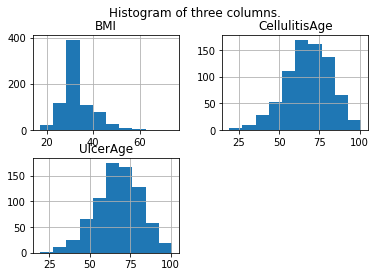

In [0]:
# Create a histogram of the 'BMI', 'UlcerAge', and CellulitisAge columns.
df[['BMI', 'UlcerAge', 'CellulitisAge']].hist()
plt.suptitle('Histogram of three columns.')
plt.show()

It is interesting to note that the CellulitisAge and UlcerAge features both peak at approximately age 60.
The BMI peaks at approximately 30. 

<Figure size 864x432 with 0 Axes>

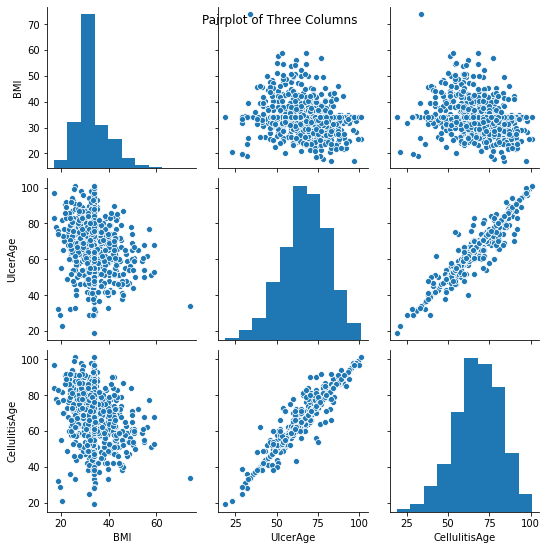

In [0]:
# Create a pairplot of the 'BMI', 'UlcerAge', and 'CellulitisAge' columns.
plt.figure(figsize=(12, 6))
sns.pairplot(df[['BMI', 'UlcerAge', 'CellulitisAge']])
plt.suptitle('Pairplot of Three Columns')
plt.show()

The pairplot confirms the linear relationship between UlcerAge and CellulitisAge and the non-liear relationship
between those two and the BMI.

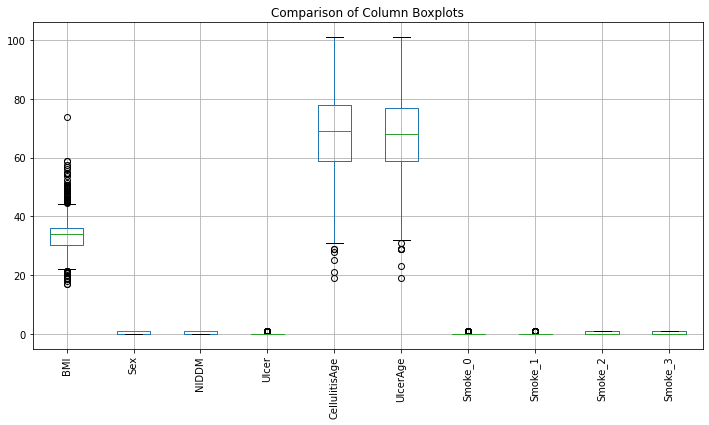

In [0]:
# Create a boxplot of the columns. In the next cell, the boxplot of 'UlcerAge' will be examined.
plt.figure(figsize=(12, 6))
df.boxplot()
plt.title('Comparison of Column Boxplots')
plt.xticks(rotation=90)
plt.show()

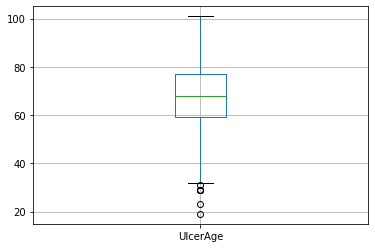

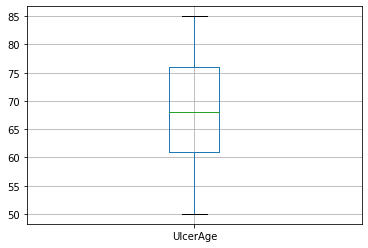

(602, 15)


In [0]:
# Create two boxplots, the first of the 'UlcerAge' column and the second of the same column with the extremes trimmed. 
df[['UlcerAge']].boxplot()
plt.show()
std = df['UlcerAge'].std()
mean = df['UlcerAge'].mean()
cut_off = df['UlcerAge'].quantile(0.75) - df['UlcerAge'].quantile(0.25) # Can also do std * 3
lower, upper = mean - cut_off, mean + cut_off
trimmed_df = df[(df['UlcerAge'] < upper)
                           & (df['UlcerAge'] > lower)]
trimmed_df[['UlcerAge']].boxplot()
plt.show()
print(trimmed_df.shape)

The same could be done with 'BMI' and 'CellulitisAge', however if all entries with extreme values in any of these three columns were removed 
there would be several hundred fewer entries. Removing the outliers would be more feasible with a much larger data set.

In [0]:
# The StandardScalar cell (below) showed an error message regarding a string being present so it is being located and changed to numeric. The change is then confirmed.
print (df[df['IDDM'].apply(lambda x: isinstance(x, str))])
df['IDDM'] = pd.to_numeric(df['IDDM'], errors='coerce')
print (df[df['IDDM'].apply(lambda x: isinstance(x, str))])
print (df[df['IDDM'].apply(lambda x: isinstance(x, object))])

           BMI  Sex  NIDDM IDDM  ... Smoke_0 Smoke_1 Smoke_2  Smoke_3
292  33.973364    1      1       ...       0       0       0        1
427  57.600000    1      1       ...       0       0       0        1
526  41.600000    1      1       ...       0       0       1        0
543  33.000000    1      1       ...       0       0       0        1

[4 rows x 15 columns]
Empty DataFrame
Columns: [BMI, Sex, NIDDM, IDDM, PVD, Neuro, Hyper, Ulcer, Cellulitis, CellulitisAge, UlcerAge, Smoke_0, Smoke_1, Smoke_2, Smoke_3]
Index: []
           BMI  Sex  NIDDM  IDDM  ... Smoke_0 Smoke_1 Smoke_2  Smoke_3
0    28.200000    0      1   0.0  ...       0       0       1        0
1    33.973364    0      0   1.0  ...       0       0       0        1
2    40.700000    1      1   0.0  ...       1       0       0        0
3    38.400000    0      0   1.0  ...       0       0       0        1
4    29.800000    1      1   0.0  ...       1       0       0        0
..         ...  ...    ...   ...  ...     .

In [0]:
# An error message in the StandardScacler cell (below) stated that there was a string. The error message in this box stated that there was an 'F' which could not be converted to numeric 
# so it is being replaced by the correct value (after checking the office records) which is 1. The change is then confirmed.
print (df[df['PVD'].apply(lambda x: isinstance(x, str))])
df['PVD'] = df['PVD'].replace('F', 1, regex=True) 
df['PVD'] = pd.to_numeric(df['PVD'], errors='coerce')
print (df[df['PVD'].apply(lambda x: isinstance(x, str))])

           BMI  Sex  NIDDM  IDDM  ... Smoke_0 Smoke_1 Smoke_2  Smoke_3
18   31.000000    1      0   1.0  ...       1       0       0        0
122  39.600000    0      1   0.0  ...       0       0       0        1
147  31.100000    0      0   1.0  ...       0       0       0        1
215  33.973364    0      0   1.0  ...       0       0       1        0

[4 rows x 15 columns]
Empty DataFrame
Columns: [BMI, Sex, NIDDM, IDDM, PVD, Neuro, Hyper, Ulcer, Cellulitis, CellulitisAge, UlcerAge, Smoke_0, Smoke_1, Smoke_2, Smoke_3]
Index: []


In [0]:
# The StandardScacler cell (below) showed an error message regarding a string being present so it is being located and changed to numeric. The change is then confirmed.
print (df[df['Neuro'].apply(lambda x: isinstance(x, str))])
df['Neuro'] = pd.to_numeric(df['Neuro'], errors='coerce')
print (df[df['Neuro'].apply(lambda x: isinstance(x, str))])

      BMI  Sex  NIDDM  IDDM  PVD  ... UlcerAge Smoke_0  Smoke_1 Smoke_2  Smoke_3
526  41.6    1      1   NaN  1.0  ...       70       0        0       1        0
533  24.9    1      0   1.0  0.0  ...       54       0        0       0        1
543  33.0    1      1   NaN  0.0  ...       50       0        0       0        1

[3 rows x 15 columns]
Empty DataFrame
Columns: [BMI, Sex, NIDDM, IDDM, PVD, Neuro, Hyper, Ulcer, Cellulitis, CellulitisAge, UlcerAge, Smoke_0, Smoke_1, Smoke_2, Smoke_3]
Index: []


In [0]:

# An error message in the StandardScacler cell (below) stated that there was a string. The error message in this box stated that there was an 'H' which could not be converted to numeric 
# in three rows so they are being replaced by the correct values (after checking the office records) which are 1, 0, and 1. The changes are then confirmed. 
print (df[df['Hyper'].apply(lambda x: isinstance(x, str))])
df['Hyper'].loc[147, 274] = 1
df['Hyper'].loc[217] = 0
df['Hyper'] = pd.to_numeric(df['Hyper'], errors='coerce')
print (df[df['Hyper'].apply(lambda x: isinstance(x, str))])   

           BMI  Sex  NIDDM  IDDM  ...  Smoke_0  Smoke_1 Smoke_2  Smoke_3
147  31.100000    0      0   1.0  ...        0        0       0        1
215  33.973364    0      0   1.0  ...        0        0       1        0
217  35.000000    1      1   0.0  ...        0        0       0        1
274  32.900000    1      1   0.0  ...        1        0       0        0

[4 rows x 15 columns]
Empty DataFrame
Columns: [BMI, Sex, NIDDM, IDDM, PVD, Neuro, Hyper, Ulcer, Cellulitis, CellulitisAge, UlcerAge, Smoke_0, Smoke_1, Smoke_2, Smoke_3]
Index: []


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
# The StandardScalar cell (below) showed an error message regarding a string being present so it is being located and changed to numeric. The change is then confirmed.
print (df[df['Cellulitis'].apply(lambda x: isinstance(x, str))])
df['Cellulitis'] = pd.to_numeric(df['Cellulitis'], errors='coerce')
print (df[df['Cellulitis'].apply(lambda x: isinstance(x, str))])

           BMI  Sex  NIDDM  IDDM  ...  Smoke_0  Smoke_1  Smoke_2  Smoke_3
5    32.900000    1      0   1.0  ...        1        0        0        0
93   49.600000    0      1   0.0  ...        0        0        1        0
110  45.200000    0      0   1.0  ...        0        0        1        0
140  33.500000    1      0   1.0  ...        1        0        0        0
292  33.973364    1      1   NaN  ...        0        0        0        1
307  40.700000    0      1   0.0  ...        0        0        0        1
481  36.400000    0      1   0.0  ...        0        0        1        0
732  28.700000    0      1   0.0  ...        0        0        0        1

[8 rows x 15 columns]
Empty DataFrame
Columns: [BMI, Sex, NIDDM, IDDM, PVD, Neuro, Hyper, Ulcer, Cellulitis, CellulitisAge, UlcerAge, Smoke_0, Smoke_1, Smoke_2, Smoke_3]
Index: []


In [0]:
# There was an error message regarding the presence of non-integers further on. If the data set had been larger those rows would just have been dropped.  
# Since there are only 760 rows, and the correct information was obtainable, the non-integers were corrected. The first two codes (which are now commented out) 
# were used to determine the number of rows and the order of the columns. The third and fourth codes (which are commented out) were used 
# to consecutively print 50 rows at a time (so that all would be visible) bringing up rows to examine them.The columns were divided so that all would be visible. The corrections were then made.
# print(df.shape)
# print(df.columns)
# print(df.loc[730:735, 'BMI':'Hyper'])
# print(df.loc[0:50, 'Cellulitis':'Smoke_3'])
df['PVD'].loc[[18, 122, 215]] = 0
df['Hyper'].loc[215] = 0
df['IDDM'].loc[[292, 427, 526, 543]] = 0
df['Neuro'].loc[[526, 533, 543]] = 0
df['Cellulitis'].loc[[5, 93, 110, 140, 481]] = 1
df['Cellulitis'].loc[[292, 307, 732]] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
# !pip install git+git://github.com/fchollet/keras.git --upgrade --no-deps
!pip install tensorflow==1.14.0
!pip install keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import BatchNormalization
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
# The features and target are separated into 'X' and 'y'.'X' is then standardized.
y = df['Ulcer'].copy().values #values makes dataframe into array to correct if order changes lose column names and index
X = df.drop(['Ulcer'], axis=1).copy().values
SS_scaler = StandardScaler()
X = SS_scaler.fit_transform(X)
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=123)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In the creation of the model, dropout layers as well as l1 and l2 regularization were attempted, but they did not improve the accuracy. 
The number of layers had to be kept low since too many neurons are not indicated for a small data set. 
A larger data set would allow for a more complex model which could yield more accurate results. This could be achieved by a larger medical organization or the combining of records from many offices. 

In [0]:
# The model is created. A wrapper is needed so that cross validation can be performed within the keras framework. 
def buildModel():
   model = Sequential() # can put parameters like input_dim and change when run
   model.add(Dense(5, input_dim=X_train.shape[1], activation='relu'))  
   model.add(Dense(4, activation='sigmoid')) 
   model.add(Dense(1, activation=None))   
   model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])   
   return model
model = buildModel()
model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 5)                 75        
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 24        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 5         
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Early stopping is instituted in case the val_loss stops improving.
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=int(5)) 
model.fit(X_train, y_train, epochs = 30, validation_split=0.2, batch_size=32, callbacks=[es]) #batch_size default is 32.Increase by 2.validation_data=(X_val, y_val)

Train on 483 samples, validate on 121 samples
Epoch 1/30
483/483 [==============================] - 0s 76us/step - loss: 3.1936 - accuracy: 0.3934 - val_loss: 3.6969 - val_accuracy: 0.4050
Epoch 2/30
483/483 [==============================] - 0s 65us/step - loss: 3.1936 - accuracy: 0.3934 - val_loss: 3.6969 - val_accuracy: 0.4050
Epoch 3/30
483/483 [==============================] - 0s 62us/step - loss: 3.1936 - accuracy: 0.3934 - val_loss: 3.6969 - val_accuracy: 0.4050
Epoch 4/30
483/483 [==============================] - 0s 61us/step - loss: 3.1936 - accuracy: 0.3934 - val_loss: 3.6969 - val_accuracy: 0.4050
Epoch 5/30
483/483 [==============================] - 0s 58us/step - loss: 3.1936 - accuracy: 0.3934 - val_loss: 3.6969 - val_accuracy: 0.4050
Epoch 6/30
483/483 [==============================] - 0s 58us/step - loss: 3.1936 - accuracy: 0.3934 - val_loss: 3.6969 - val_accuracy: 0.4050
Epoch 00006: early stopping


In [0]:
# The model is evaluated with various metrics The training and testing accuracy scores are close. This indicated that the model is not overfitted. 
# The result for model.evaluate returns first the loss and then the accuracy.

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, log_loss, confusion_matrix

print("Final loss value:",model.evaluate(X_train, y_train))
predTrain = model.predict(X_train) 
predTest = model.predict(X_test) > 0.5  # This is positive for ulcer, has True and False instead of 0 and 1 and is binary
accuracyTrain = model.evaluate(X_train, y_train)
accuracyTest = model.evaluate(X_test, y_test)
accuracyScore = accuracy_score(y_test, predTest)
ll = log_loss(y_test, predTest)
auc = roc_auc_score(y_test, predTest)
classReport = classification_report(y_test, predTest)
conf_mat = confusion_matrix(y_test, predTest)
print('Accuracy of Training Data:', accuracyTrain)
print('Accuracy of Testing Data:', accuracyTest)
print('Accuracy Score:', accuracyScore)
print('Log loss:', ll)
print('AUC:', auc)
print('Classification Report:') 
print(classReport)
print('Confusion Matrix:') 
print(conf_mat)

604/604 [==============================] - 0s 191us/step
Final loss value: [1.5998280403629834, 0.2665562927722931]
151/151 [==============================] - 0s 87us/step
Accuracy of Training Data: [1.5998280403629834, 0.2665562927722931]
Accuracy of Testing Data: [1.5381499742040572, 0.21854305267333984]
Accuracy Score: 0.2185430463576159
Log loss: 26.991186539727106
AUC: 0.5127692307692308
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.06      0.12       125
           1       0.18      0.96      0.30        26

    accuracy                           0.22       151
   macro avg       0.53      0.51      0.21       151
weighted avg       0.77      0.22      0.15       151

Confusion Matrix:
[[  8 117]
 [  1  25]]


In [0]:
# Determine the cross validation score. The mean accuracy is lower, a larger data set would give a better indication.
from sklearn.model_selection import cross_val_score
def scorer(model, X, y):
  return accuracy_score(y, model.predict(X))
model2 = KerasClassifier(buildModel)
# Check how your keras model performs with 5 fold cross-validation
kfold = cross_val_score(model2, X, y, cv=5, scoring=scorer)
# Print the mean accuracy per fold
print('Mean Accuracy Per Fold:', kfold.mean())
# Print the standard deviation per fold
print('Standard Deviation Per Fold:', kfold.std())

Epoch 1/1
604/604 [==============================] - 0s 281us/step - loss: 2.0555 - accuracy: 0.7980
Epoch 1/1
604/604 [==============================] - 0s 283us/step - loss: 2.9910 - accuracy: 0.7036
Epoch 1/1
604/604 [==============================] - 0s 302us/step - loss: 3.2178 - accuracy: 0.0000e+00
Epoch 1/1
604/604 [==============================] - 0s 314us/step - loss: 0.5574 - accuracy: 0.7914
Epoch 1/1
604/604 [==============================] - 0s 332us/step - loss: 3.0901 - accuracy: 0.0033
Mean Accuracy Per Fold: 0.7960264900662253
Standard Deviation Per Fold: 0.019375813030897752
